# 앙상블학습과 랜덤포레스트

#### 투표 기반의 분류기
- 각 분류기의 예측을 모아서 가장 많이 선택된 클래스 예측
- 다수결 투표로 정해지는 분류기를 직접투표 분류기

In [15]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [9]:
X,y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [12]:

# 투표기반 분류기
log_clf = LogisticRegression(random_state = 42)
rnd_clf = RandomForestClassifier(random_state = 42)
svm_clf = SVC(random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [14]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 간접투표
- 개별 분류기의 예측 평균을 내어 확률이 가장 높은 클래스를 예측 할 수 있음
- 직접투표보다 성능 높음, voting = 'hard'를 voting = 'soft'로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨
- SVC 기본값에서는 클래스 확률을 제공하지 않음 probability 매개변수를 Ture로 지정해야 함 이렇게하면 클래스 확률을 추정하기 위해 교차 검즈을 사용하므로 훈련속도가 느려지지만 SVC에서 predict_proba()메서드 사용 가능

### 배깅과 페이스팅
 - 배깅 : 훈련세트에서 중복을 허용하여 샘플링 하는 방식
 - 페이스팅 : 훈련세트에서 중복을 허용하지 않고 샘플링 하는 방식

- 같은 훈련샘플을 여러개의 예측기에 걸쳐 사용할 수 있음, 하지만 배깅만이 한 예측기를 위해 같은 훈련샘플을 여러 번 샘플링 가능

- CPU코어나 서버에서 병렬로 학습시킬 수 있음, 예측도 병렬로 수행가능, 이런 확장성때문에 배깅과 페이스팅 인기 높음

- 예측기에 예측을 모아서 새로운 샘플에 대한 예측을 만듬
- 수집 함수는 전형적으로 분류일때는 통계적 최빈값(가장 많은 예측 결과), 회귀에 대해서는 평균을 계산
- 일반적으로 앙상ㅇ블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련할때와 비교해 편향은 비슷하지만 분산은 줄어든다 

In [17]:
# 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, n_jobs = -1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


단일결정트리(왼쪽), 500개 트리로 만든 배깅 앙상블(오른쪽) 비교
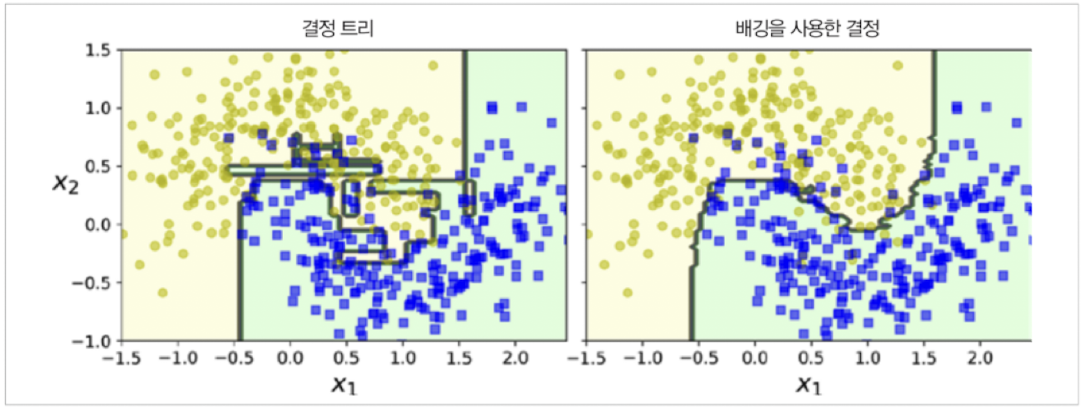

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시킴, 페이스팅보다 편향 조금 더 높음, 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴, 
전반적으로 배깅이 더 나은 모델을 만들기 떄문에 일반적으로 더 선호 CPU파워, 시간에 여유가 이싿면 교차 검증으로 배깅과 페이스팅을 모두 평가 해서 나은 쪽을 선택하는 것이 좋음

#### oob평가
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 사용되고 사용되지 않는 샘플이 있을수도 있음
- BaggingClassifier는 기본값으로 중복을 허용, 훈련세트의 크기만큼인 m개 샘플을 선택, 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미, 선택되지 않은 훈련 샘플의 나머지 37%를 obb샘플이라 부름, 예측기마다 다름
- 앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻음
- sklearn에서 BaggingClassifier를 만들 때 obb_score=True 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap=True, n_jobs= -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

In [21]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [25]:
# oob 샘플에 대한 결정 합수 값
bag_clf.oob_decision_function_
#첫번째 훈련 샘플이 양성일 확률 약58%, 음성일 확률 약41%

array([[0.41081081, 0.58918919],
       [0.34302326, 0.65697674],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08762887, 0.91237113],
       [0.37037037, 0.62962963],
       [0.01648352, 0.98351648],
       [0.99428571, 0.00571429],
       [0.98857143, 0.01142857],
       [0.72340426, 0.27659574],
       [0.00985222, 0.99014778],
       [0.80110497, 0.19889503],
       [0.85204082, 0.14795918],
       [0.97175141, 0.02824859],
       [0.06122449, 0.93877551],
       [0.        , 1.        ],
       [0.99014778, 0.00985222],
       [0.96089385, 0.03910615],
       [1.        , 0.        ],
       [0.02173913, 0.97826087],
       [0.36125654, 0.63874346],
       [0.92268041, 0.07731959],
       [1.        , 0.        ],
       [0.97142857, 0.02857143],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64880952, 0.35119048],
       [0.